In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from joblib import dump
from scipy.spatial import distance
from scipy.stats.distributions import  chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Exploración de datos

In [2]:
df = pd.read_csv('smoking_driking_dataset_Ver01.csv')
df.head().T

,0,1,2,3,4
sex,Male,Male,Male,Male,Male
age,35,30,40,50,50
height,170,180,165,175,165
weight,75,80,75,80,60
waistline,90.0,89.0,91.0,91.0,80.0
sight_left,1.0,0.9,1.2,1.5,1.0
sight_right,1.0,1.2,1.5,1.2,1.2
hear_left,1.0,1.0,1.0,1.0,1.0
hear_right,1.0,1.0,1.0,1.0,1.0
SBP,120.0,130.0,120.0,145.0,138.0


Dummificación de las variables categoricas

In [3]:
df['DRK_YN'] = np.select( [(df['DRK_YN'] == 'Y'),(df['DRK_YN'] == 'N')], [0,1] )
df['sex'] = np.select( [(df['sex'] == 'Male'),(df['sex'] == 'Female')], [0,1] )
df[['DRK_YN','sex']].head(5).T

,0,1,2,3,4
DRK_YN,0,1,1,1,1
sex,0,0,0,0,0


In [4]:
df.columns

Index(['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN'],
      dtype='object')

In [5]:
df.shape

(991346, 24)

Tenemos 991346 registros para entrenar testear y validar

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,991346.0,0.468990,0.499038,0.0,0.0,0.0,1.0,1.0
age,991346.0,47.614491,14.181339,20.0,35.0,45.0,60.0,85.0
height,991346.0,162.240625,9.282957,130.0,155.0,160.0,170.0,190.0
weight,991346.0,63.284050,12.514241,25.0,55.0,60.0,70.0,140.0
waistline,991346.0,81.233358,11.850323,8.0,74.1,81.0,87.8,999.0
sight_left,991346.0,0.980834,0.605949,0.1,0.7,1.0,1.2,9.9
sight_right,991346.0,0.978429,0.604774,0.1,0.7,1.0,1.2,9.9
hear_left,991346.0,1.031495,0.174650,1.0,1.0,1.0,1.0,2.0
hear_right,991346.0,1.030476,0.171892,1.0,1.0,1.0,1.0,2.0
SBP,991346.0,122.432498,14.543148,67.0,112.0,120.0,131.0,273.0


In [7]:
pd.DataFrame([df.isna().sum(), df.isnull().sum()]).transpose().rename(columns={0:'nan', 1: 'null'})

,nan,null
sex,0,0
age,0,0
height,0,0
weight,0,0
waistline,0,0
sight_left,0,0
sight_right,0,0
hear_left,0,0
hear_right,0,0
SBP,0,0


In [8]:
means = df.mean(axis = 0, numeric_only= True)
means

sex                   0.468990
age                  47.614491
height              162.240625
weight               63.284050
waistline            81.233358
sight_left            0.980834
sight_right           0.978429
hear_left             1.031495
hear_right            1.030476
SBP                 122.432498
DBP                  76.052627
BLDS                100.424447
tot_chole           195.557020
HDL_chole            56.936800
LDL_chole           113.037692
triglyceride        132.141751
hemoglobin           14.229824
urine_protein         1.094224
serum_creatinine      0.860467
SGOT_AST             25.989308
SGOT_ALT             25.755051
gamma_GTP            37.136347
SMK_stat_type_cd      1.608122
DRK_YN                0.500187
dtype: float64

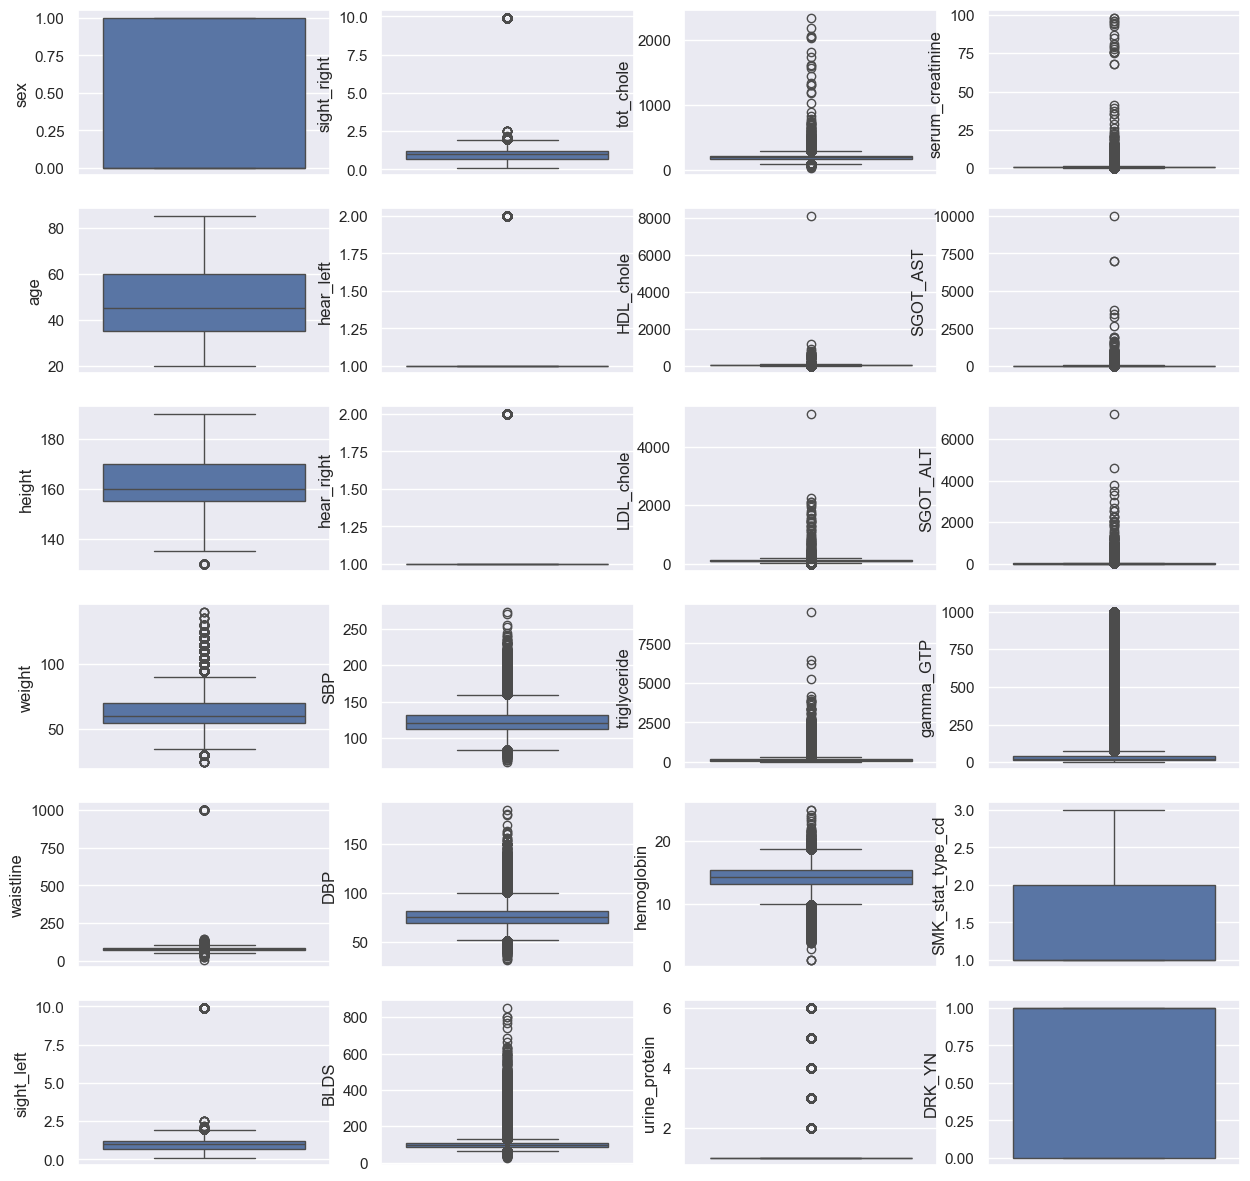

In [9]:
sns.set()
COLS = 6
ROWS = 4
fig, axes = plt.subplots(COLS, ROWS)
fig.set_figheight(15)
fig.set_figwidth(15)
i = 0
for col in df.columns:
    sns.boxplot(data=df[col], ax=axes[i%COLS,i//COLS])
    i+=1
    

Existen varias variables con datos atipicos

In [10]:
corr = df.corr()
corr

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
sex,1.000000,0.083225,-0.722774,-0.581707,-0.344725,-0.099016,-0.101522,-0.002926,0.000751,-0.176245,...,0.005210,-0.216283,-0.669417,-0.020184,-0.245956,-0.092943,-0.196751,-0.257229,-0.591004,0.368726
age,0.083225,1.000000,-0.398501,-0.195337,0.127170,-0.172096,-0.167684,0.203021,0.198693,0.265530,...,0.029497,0.043549,-0.173081,0.041497,0.022819,0.059408,-0.020506,0.017391,-0.126031,0.284587
height,-0.722774,-0.398501,1.000000,0.668823,0.263945,0.139141,0.138529,-0.081159,-0.082456,0.035030,...,-0.015450,0.137611,0.531898,0.002298,0.171256,0.039203,0.144842,0.162340,0.467317,-0.374566
weight,-0.581707,-0.195337,0.668823,1.000000,0.637173,0.088901,0.088707,-0.044498,-0.045709,0.250770,...,0.067859,0.283774,0.499491,0.029281,0.153885,0.099652,0.276440,0.221881,0.366499,-0.264282
waistline,-0.344725,0.127170,0.263945,0.637173,1.000000,0.004511,0.006158,0.033224,0.031012,0.272323,...,0.063416,0.249436,0.291730,0.043132,0.098421,0.096858,0.212267,0.186988,0.205485,-0.092993
sight_left,-0.099016,-0.172096,0.139141,0.088901,0.004511,1.000000,0.307985,-0.039428,-0.040998,-0.035617,...,0.003013,0.010599,0.085896,-0.010253,0.020309,-0.005427,0.018815,0.013566,0.064194,-0.077379
sight_right,-0.101522,-0.167684,0.138529,0.088707,0.006158,0.307985,1.000000,-0.040764,-0.038895,-0.033994,...,0.002155,0.012265,0.086847,-0.010897,0.021447,-0.004600,0.018920,0.016491,0.065051,-0.074806
hear_left,-0.002926,0.203021,-0.081159,-0.044498,0.033224,-0.039428,-0.040764,1.000000,0.536890,0.056065,...,-0.014621,0.002095,-0.036058,0.019754,0.015254,0.011283,-0.007907,0.002991,-0.021245,0.058337
hear_right,0.000751,0.198693,-0.082456,-0.045709,0.031012,-0.040998,-0.038895,0.536890,1.000000,0.057436,...,-0.013438,0.002155,-0.036703,0.018264,0.012959,0.010763,-0.008687,0.003548,-0.022330,0.058230
SBP,-0.176245,0.265530,0.035030,0.250770,0.272323,-0.035617,-0.033994,0.056065,0.057436,1.000000,...,0.033619,0.186003,0.166530,0.063518,0.062605,0.081478,0.117613,0.161434,0.084918,-0.033149


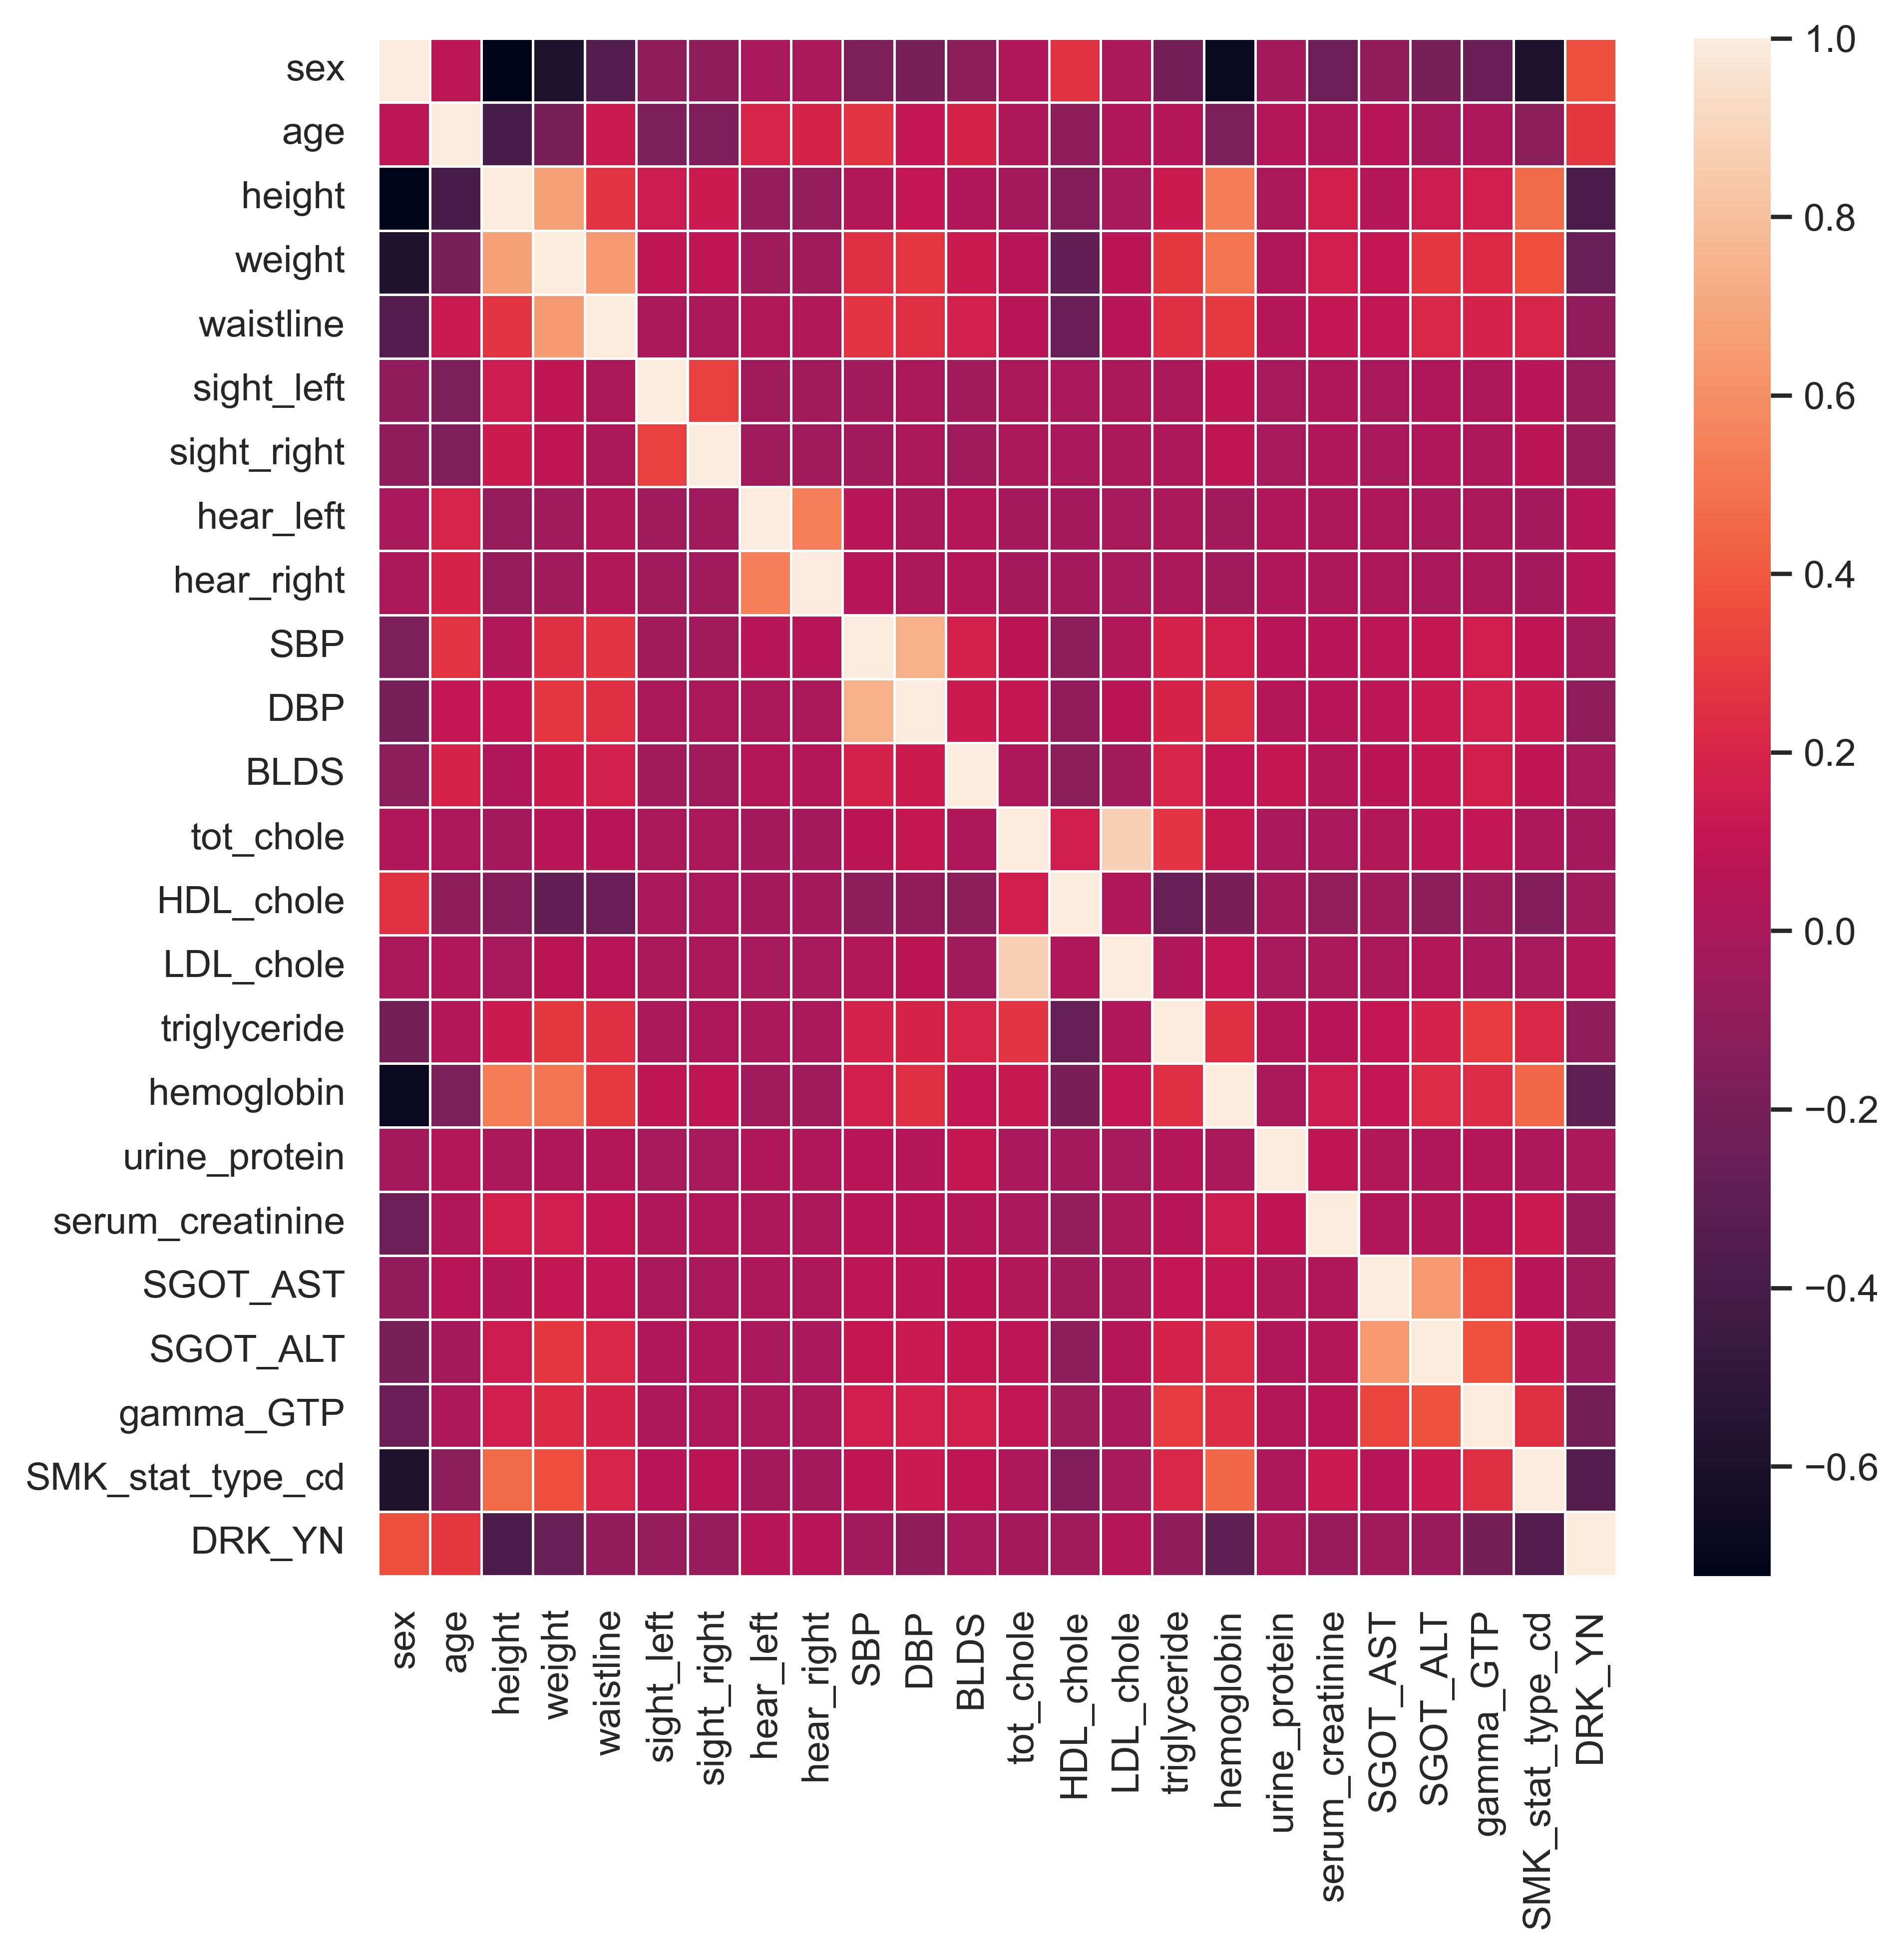

In [11]:
plt.figure(figsize=(8,8), dpi=500)
sns.heatmap(corr, fmt=".2f", linewidth=.5)
plt.show()

# Eliminación de datos atipicos

In [12]:
invCov = np.linalg.inv(df.cov())
mala = df.apply(lambda x: distance.mahalanobis(x, means,invCov),axis = 1)

In [13]:
deg_fred = len(df.columns) -2
a_borrar = mala[ mala >= chi2.ppf(.4,df=deg_fred)]
a_borrar.size

1478

Eliminamos 1478 registros

In [14]:
df['dist_mahalanobis'] =  mala
df_limpio = df[ df['dist_mahalanobis'] <= chi2.ppf(.5,df=deg_fred)].copy()
df_limpio = sm.add_constant(df_limpio)


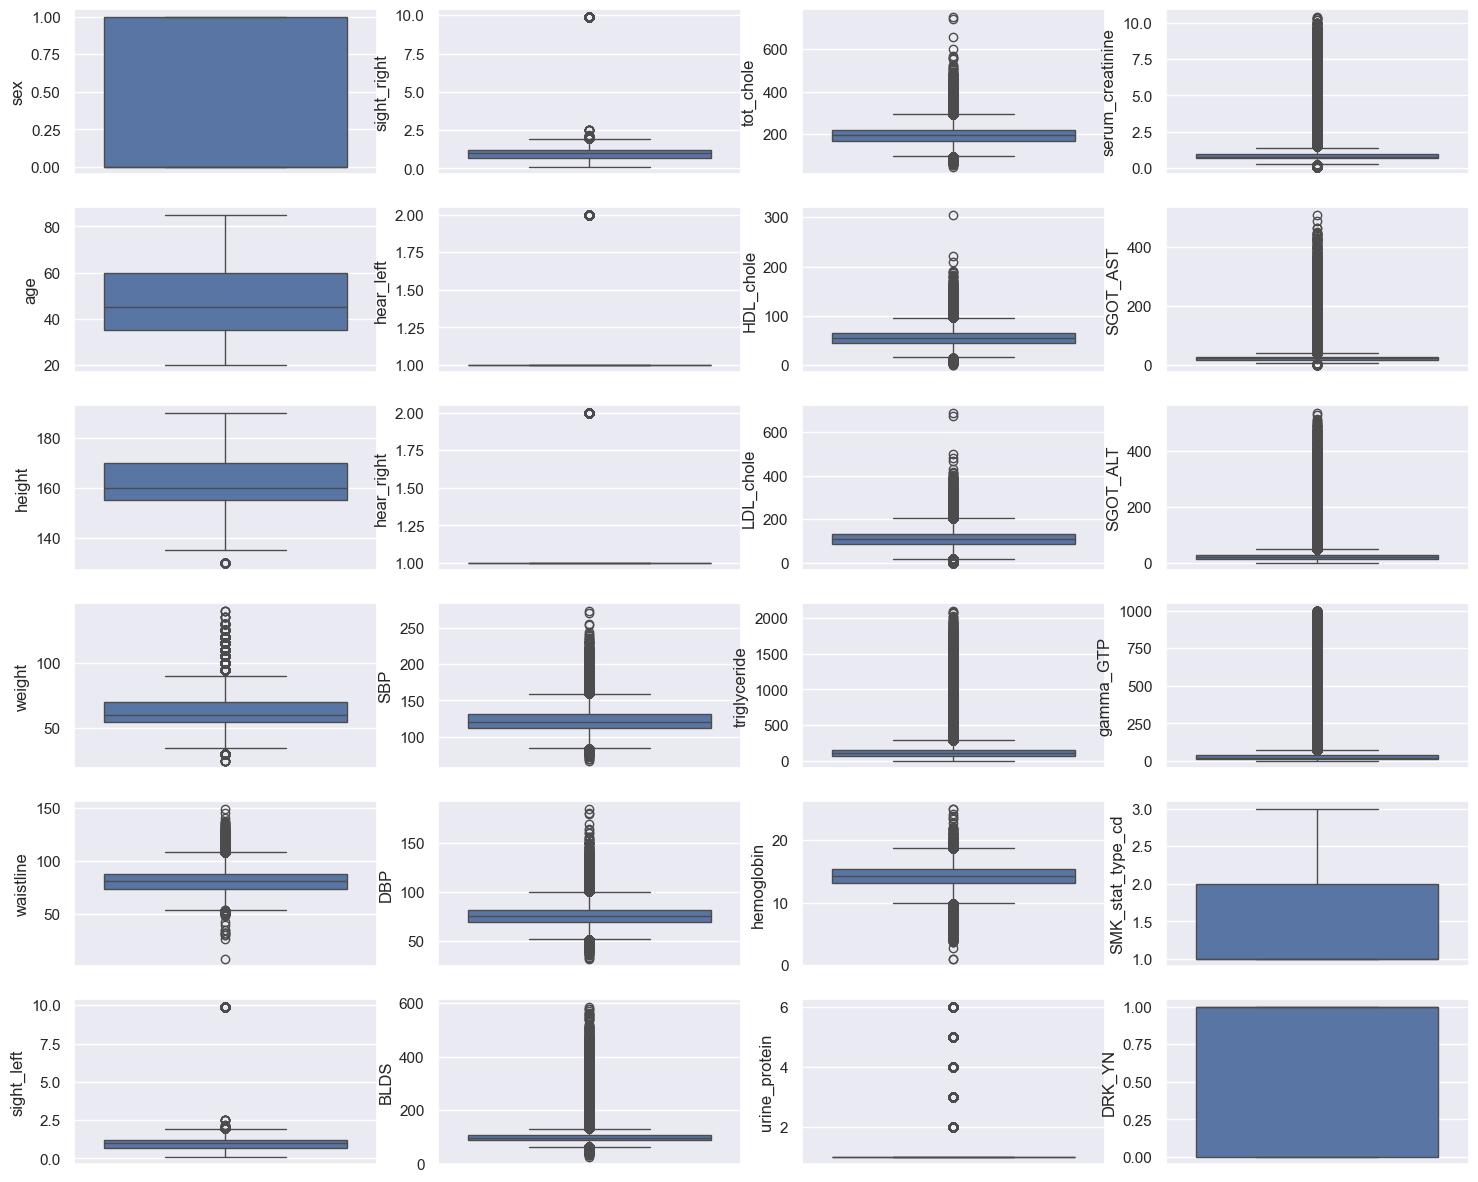

In [15]:
sns.set()
COLS = 6
ROWS = 4
fig, axes = plt.subplots(COLS, ROWS)
fig.set_figheight(15)
fig.set_figwidth(18)
i = 0
for col in df_limpio.columns[1:-1]:
    sns.boxplot(data=df_limpio[col], ax=axes[i%COLS,i//COLS])
    i+=1

Las graficas se ven más agrupadas:
Para cuantificarlo usamos eL determinante de la matriz de covarianza nos habla de que tan dispersos estan los puntos
se puede ver como luego de la limpieza de los datos (y eliminación de outliers) están menos dispersos

In [19]:
np.linalg.det(df.cov()) , np.linalg.det(df_limpio.drop(inplace=False, columns=['const']).cov())


(3.5588001706737925e+27, 2.0350639909804957e+24)

In [16]:
df.iloc[a_borrar.index]

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN,dist_mahalanobis
76,0,65,165,70,94.0,9.9,9.9,2.0,1.0,146.0,...,89.0,15.6,1.0,0.7,19.0,16.0,29.0,2.0,0,20.289148
1641,1,60,135,35,77.5,0.1,0.1,1.0,1.0,118.0,...,203.0,13.0,1.0,0.6,151.0,55.0,999.0,1.0,0,22.167792
2105,0,45,165,45,62.5,0.7,0.7,1.0,1.0,129.0,...,80.0,17.7,1.0,10.0,31.0,18.0,22.0,3.0,0,20.197355
2604,1,60,150,60,89.0,9.9,9.9,2.0,2.0,166.0,...,189.0,13.1,1.0,0.7,39.0,34.0,162.0,1.0,1,20.764814
4708,0,40,170,55,74.0,1.0,0.7,1.0,1.0,126.0,...,66.0,14.6,1.0,0.9,911.0,430.0,125.0,3.0,0,40.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987902,0,60,165,60,80.0,9.9,0.5,2.0,2.0,116.0,...,136.0,14.1,4.0,0.6,25.0,12.0,56.0,2.0,0,21.303341
988024,0,60,160,45,80.0,1.0,0.8,1.0,1.0,140.0,...,236.0,15.9,1.0,0.6,91.0,49.0,999.0,3.0,0,21.327987
990284,0,60,160,70,86.0,9.9,9.9,1.0,1.0,160.0,...,90.0,13.9,3.0,3.3,19.0,17.0,33.0,1.0,1,20.275397
990621,0,55,160,65,87.9,0.8,0.7,2.0,1.0,127.0,...,806.0,13.3,1.0,0.7,69.0,15.0,973.0,2.0,0,22.211857


Definimos un umbral de 90% de correlación para eliminar columnas, sin embargo no exiten columas con correlación mayor o igual a .9

In [17]:
columnas = corr.columns
corr2 = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
corr2 = corr2.stack().reset_index()
corr2.columns = ['Row','Column','Value']
corr2
high_cov = corr2[(corr2['Value'].abs() >= .90)&(corr2['Column'] != corr2['Row'])]
high_cov

C:\Users\DELL\AppData\Local\Temp\ipykernel_20664\1232893127.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr2 = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))


,Row,Column,Value


In [18]:
df_limpio.columns

Index(['const', 'sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN', 'dist_mahalanobis'],
      dtype='object')

In [20]:
np.linalg.cond(df.cov()) , np.linalg.cond(df_limpio.drop(inplace=False, columns=['const']).cov()) 

(791531.0314378368, 727542.1556554794)

In [21]:
df_limpio.DRK_YN.value_counts()

1    495439
0    494893
Name: DRK_YN, dtype: int64

La variable a predecir está equilibrada por lo que no es requerido realizar procedimientos adicionales (under u oversampling)

## Dividimos los datos

In [22]:
X_columns = ['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'const']
Y_column = 'DRK_YN'

X_train, X_aux, Y_train, Y_aux = train_test_split(df_limpio[X_columns], df_limpio[Y_column], stratify =  df_limpio[Y_column],  test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_aux, Y_aux, stratify =  Y_aux,  test_size=0.5, random_state=42)
del X_aux, Y_aux

In [23]:
### Escalar el conjunto de datos
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)
X_test_z = scaler.transform(X_test)

# MODELOS

### Regresión logistica - modelo estadistico

In [24]:
modelLogit = sm.Logit(Y_train,np.delete(X_train_z, 22, 1))
resultLogit =  modelLogit.fit()
resultLogit.summary()

Optimization terminated successfully.
         Current function value: 0.549203
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 DRK_YN   No. Observations:               594199
Model:                          Logit   Df Residuals:                   594177
Method:                           MLE   Df Model:                           21
Date:                Fri, 01 Dec 2023   Pseudo R-squ.:                  0.2077
Time:                        19:14:19   Log-Likelihood:            -3.2634e+05
converged:                       True   LL-Null:                   -4.1187e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6956      0.006    119.928      0.000       0.684       0.707
x2             0.5939      0.004    141.437      0.000       0.586       0.602
x3            -0.1666      0.006    -28.324      0.000      -0.178      -0.155
x4            -0.0366      0.008     -4.869      0.000      -0.051      -0.022
x5            -0.0442      0.006     -7.105      0.000      -0.056      -0.032
x6            -0.0004      0.003     -0.126      0.899      -0.007       0.006
x7             0.0106      0.003      3.199      0.001       0.004       0.017
x8             0.0077      0.004      2.052      0.040       0.000       0.015
x9             0.0133      0.004      3.529      0.000       0.006       0.021
x10            0.0409      0.005      8.419      0.000       0.031       0.050
x11           -0.1330      0.005    -28.375      0.000      -0.142      -0.124
x12           -0.0136      0.003     -4.113      0.000      -0.020      -0.007
x13           -0.0029      0.021     -0.138      0.890      -0.045       0.039
x14           -0.3951      0.009    -45.046      0.000      -0.412      -0.378
x15            0.0781      0.019      4.013      0.000       0.040       0.116
x16           -0.1390      0.010    -14.569      0.000      -0.158      -0.120
x17           -0.0642      0.004    -14.818      0.000      -0.073      -0.056
x18            0.0074      0.003      2.363      0.018       0.001       0.013
x19            0.1133      0.004     26.454      0.000       0.105       0.122
x20           -0.1961      0.006    -33.486      0.000      -0.208      -0.185
x21            0.4376      0.006     74.929      0.000       0.426       0.449
x22           -0.6693      0.006   -102.975      0.000      -0.682      -0.657
==============================================================================
"""

Acá detectamos 2 variables que posiblemente no tengan significancia estadistica (sight_left y la tot_chole), para probarlo, decidimos ejecutar la regresión con regularización LASSO para eliminar las 2 variables

In [25]:
modelLs = sm.Logit(Y_train,np.delete(X_train_z, 22, 1))
resultLs = modelLs.fit_regularized(start_params=None, method='l1', alpha= 1e-1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.549203785704584
            Iterations: 74
            Function evaluations: 74
            Gradient evaluations: 74


c:\Maestria\P integrador\venv\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 19 out of 22 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
c:\Maestria\P integrador\venv\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [26]:
resultLs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 DRK_YN   No. Observations:               594199
Model:                          Logit   Df Residuals:                   594177
Method:                           MLE   Df Model:                           21
Date:                Fri, 01 Dec 2023   Pseudo R-squ.:                  0.2077
Time:                        19:14:25   Log-Likelihood:            -3.2634e+05
converged:                       True   LL-Null:                   -4.1187e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6956      0.006    119.929      0.000       0.684       0.707
x2             0.5939      0.004    141.438      0.000       0.586       0.602
x3            -0.1666      0.006    -28.325      0.000      -0.178      -0.155
x4            -0.0366      0.008     -4.867      0.000      -0.051      -0.022
x5            -0.0443      0.006     -7.107      0.000      -0.056      -0.032
x6            -0.0004      0.003     -0.126      0.900      -0.007       0.006
x7             0.0106      0.003      3.197      0.001       0.004       0.017
x8             0.0077      0.004      2.050      0.040       0.000       0.015
x9             0.0133      0.004      3.529      0.000       0.006       0.021
x10            0.0409      0.005      8.418      0.000       0.031       0.050
x11           -0.1330      0.005    -28.374      0.000      -0.142      -0.124
x12           -0.0136      0.003     -4.117      0.000      -0.020      -0.007
x13           -0.0029      0.021     -0.138      0.890      -0.045       0.039
x14           -0.3951      0.009    -45.047      0.000      -0.412      -0.378
x15            0.0782      0.019      4.013      0.000       0.040       0.116
x16           -0.1390      0.010    -14.569      0.000      -0.158      -0.120
x17           -0.0642      0.004    -14.817      0.000      -0.073      -0.056
x18            0.0074      0.003      2.365      0.018       0.001       0.013
x19            0.1133      0.004     26.453      0.000       0.105       0.122
x20           -0.1961      0.006    -33.484      0.000      -0.208      -0.185
x21            0.4376      0.006     74.926      0.000       0.426       0.449
x22           -0.6693      0.006   -102.975      0.000      -0.682      -0.657
==============================================================================
"""

Confirmamos con Lasso que estas variables pueden estar en 0 por lo que se decide no utilizarlas en las regresiones


In [27]:
X_train_z_log = np.delete(X_train_z, [5,12], 1)
X_val_z_log   = np.delete(X_val_z, [5,12], 1)
X_test_z_log  = np.delete(X_test_z, [5,12], 1)
X_columns_log = ['sex', 'age', 'height', 'weight', 'waistline', 
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'const']


In [28]:
X_train_z_log.shape, Y_train.shape

((594199, 21), (594199,))

FInalmente ejecutamos una regresión logistica sin las 2 columans eliminadas

In [29]:
modelLogit = sm.Logit(Y_train,np.delete(X_train_z_log, 20, 1))
resultLogit =  modelLogit.fit()
resultLogit.summary()

Optimization terminated successfully.
         Current function value: 0.549203
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 DRK_YN   No. Observations:               594199
Model:                          Logit   Df Residuals:                   594179
Method:                           MLE   Df Model:                           19
Date:                Fri, 01 Dec 2023   Pseudo R-squ.:                  0.2077
Time:                        19:14:28   Log-Likelihood:            -3.2634e+05
converged:                       True   LL-Null:                   -4.1187e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6956      0.006    120.020      0.000       0.684       0.707
x2             0.5940      0.004    141.980      0.000       0.586       0.602
x3            -0.1666      0.006    -28.327      0.000      -0.178      -0.155
x4            -0.0366      0.008     -4.872      0.000      -0.051      -0.022
x5            -0.0443      0.006     -7.109      0.000      -0.056      -0.032
x6             0.0105      0.003      3.297      0.001       0.004       0.017
x7             0.0077      0.004      2.052      0.040       0.000       0.015
x8             0.0133      0.004      3.531      0.000       0.006       0.021
x9             0.0409      0.005      8.420      0.000       0.031       0.050
x10           -0.1330      0.005    -28.384      0.000      -0.142      -0.124
x11           -0.0136      0.003     -4.113      0.000      -0.020      -0.007
x12           -0.3962      0.004   -108.563      0.000      -0.403      -0.389
x13            0.0755      0.003     24.131      0.000       0.069       0.082
x14           -0.1402      0.004    -34.976      0.000      -0.148      -0.132
x15           -0.0642      0.004    -14.829      0.000      -0.073      -0.056
x16            0.0074      0.003      2.365      0.018       0.001       0.013
x17            0.1133      0.004     26.458      0.000       0.105       0.122
x18           -0.1960      0.006    -33.491      0.000      -0.208      -0.185
x19            0.4376      0.006     74.943      0.000       0.426       0.449
x20           -0.6694      0.006   -103.044      0.000      -0.682      -0.657
==============================================================================
"""

In [30]:
y_pred_score = resultLogit.predict(np.delete(X_val_z_log, 20, 1))
y_pred = (y_pred_score>.5).astype(int)

# Mostrar la matriz de confusión y el informe de clasificación
print("Matriz de confusión:")
print(confusion_matrix(Y_val, y_pred))


accuracy = accuracy_score(Y_val, y_pred)
precision = precision_score(Y_val, y_pred)
recall = recall_score(Y_val, y_pred)
f1_sc = f1_score(Y_val, y_pred)
roc_auc = roc_auc_score(Y_val, y_pred_score)

print(f"Accuracy del modelo: {accuracy}")
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1_sc}')
print(f'ROC-AUC: {roc_auc}')

mod_metrics = {
    'Model' : 'Regresión logist',
    'Accuracy': accuracy,
    'Precision' :precision,
    'Recall': recall,
    'F1': f1_sc,
    'ROC-AUC': roc_auc
}
models_metrics = pd.DataFrame([mod_metrics])

Matriz de confusión:
[[70114 28864]
 [26458 72630]]
Accuracy del modelo: 0.7206890632415458
Precision: 0.7156088044613474
Recall: 0.7329848215727435
F1: 0.724192599535352
ROC-AUC: 0.7951508387747648


In [ ]:
y_pred_score = resultLogit.predict(np.delete(X_val_z_log, 20, 1))
y_pred = (y_pred_score>.5).astype(int)

# Mostrar la matriz de confusión y el informe de clasificación
print("Matriz de confusión:")
print(confusion_matrix(Y_val, y_pred))


accuracy = accuracy_score(Y_val, y_pred)
precision = precision_score(Y_val, y_pred)
recall = recall_score(Y_val, y_pred)
f1_sc = f1_score(Y_val, y_pred)
roc_auc = roc_auc_score(Y_val, y_pred_score)

print(f"Accuracy del modelo: {accuracy}")
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1_sc}')
print(f'ROC-AUC: {roc_auc}')

mod_metrics = {
    'Model' : 'Regresión logist',
    'Accuracy': accuracy,
    'Precision' :precision,
    'Recall': recall,
    'F1': f1_sc,
    'ROC-AUC': roc_auc
}
models_metrics = pd.DataFrame([mod_metrics])

Matriz de confusión:
[[70114 28864]
 [26458 72630]]
Accuracy del modelo: 0.7206890632415458
Precision: 0.7156088044613474
Recall: 0.7329848215727435
F1: 0.724192599535352
ROC-AUC: 0.7951508387747648


In [31]:
models_metrics

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Regresión logist,0.720689,0.715609,0.732985,0.724193,0.795151


Estos son los efectos marginales que pueden funcionar como interpretadores del efecto de las variables en la salida

In [32]:
#Efectos marginales
### Efecto marginal para el escenario del cancer
margeff1 = resultLogit.get_margeff()
print(margeff1.margeff)

[ 0.12881498  0.1100003  -0.03084601 -0.00677828 -0.00819655  0.00194831
  0.00142962  0.00246748  0.00756879 -0.02463487 -0.00251389 -0.0733675
  0.01398227 -0.02595586 -0.01188846  0.00136526  0.02097657 -0.03630772
  0.0810466  -0.12396329]


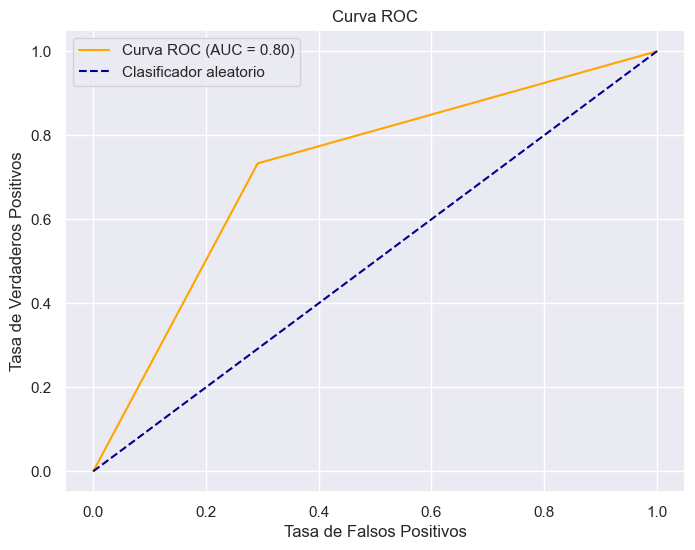

In [33]:
### Curva ROC
fpr, tpr, thresholds = roc_curve(Y_val, y_pred)


# Graficar la curva ROC
plt.figure('ROC Regresion Logistica',figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

### Regresión logistica - Machine Learning

In [82]:
model1 = LogisticRegression(random_state=0)
result1 = model1.fit(X_train_z_log,Y_train)
df_vars = pd.DataFrame({'vars':X_columns_log})
df_vars['Coef'] = result1.coef_[0]
df_vars.sort_values('Coef', key = abs)

,vars,Coef
20,const,0.000000
6,hear_left,0.007491
15,urine_protein,0.007563
5,sight_right,0.010621
7,hear_right,0.013032
10,BLDS,-0.013110
3,weight,-0.036736
8,SBP,0.039575
4,waistline,-0.044267
14,hemoglobin,-0.064388


In [35]:
y_pred = result1.predict(X_val_z_log)
y_pred_score = result1.predict_proba(X_val_z_log)[:,1]

In [36]:
# Calcular la precisión del modelo

# Mostrar la matriz de confusión y el informe de clasificación
print("Matriz de confusión:")
print(confusion_matrix(Y_val, y_pred))


accuracy = accuracy_score(Y_val, y_pred)
precision = precision_score(Y_val, y_pred)
recall = recall_score(Y_val, y_pred)
f1_sc = f1_score(Y_val, y_pred)
roc_auc = roc_auc_score(Y_val, y_pred_score)

print(f"Accuracy del modelo: {accuracy}")
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1_sc}')
print(f'ROC-AUC: {roc_auc}')

mod_metrics = {
    'Model' : 'Regresión logist SKLEARN',
    'Accuracy': accuracy,
    'Precision' :precision,
    'Recall': recall,
    'F1': f1_sc,
    'ROC-AUC': roc_auc
}
models_metrics = models_metrics.append(mod_metrics, ignore_index=True)


Matriz de confusión:
[[70867 28111]
 [27172 71916]]
Accuracy del modelo: 0.720885967303828
Precision: 0.7189658792126126
Recall: 0.7257791054416276
F1: 0.7223564271903171
ROC-AUC: 0.7952642137800916


C:\Users\DELL\AppData\Local\Temp\ipykernel_20664\1695194560.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_metrics = models_metrics.append(mod_metrics, ignore_index=True)


In [37]:
models_metrics

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Regresión logist,0.720689,0.715609,0.732985,0.724193,0.795151
1,Regresión logist SKLEARN,0.720886,0.718966,0.725779,0.722356,0.795264


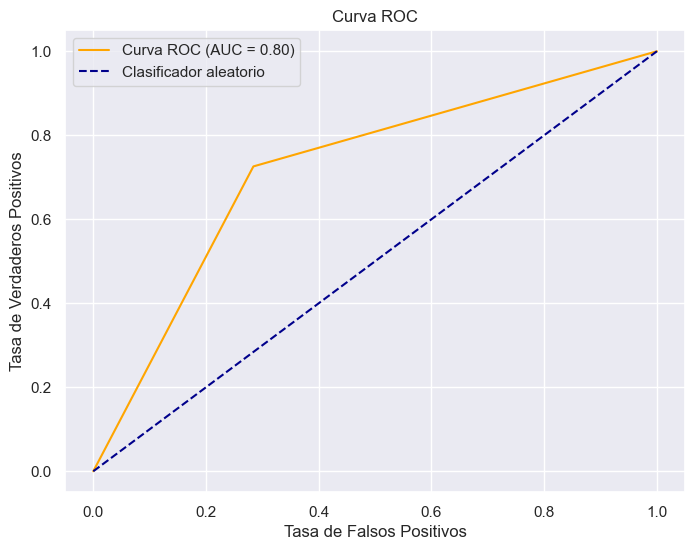

In [38]:
### Curva ROC
fpr, tpr, thresholds = roc_curve(Y_val, y_pred)


# Graficar la curva ROC
plt.figure('ROC Regresion Logistica',figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()


### Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

In [40]:
model1 = GaussianNB()
result1 = model1.fit(X_train_z,Y_train)

In [41]:
y_pred = result1.predict(X_val_z)
y_pred_score = result1.predict_proba(X_val_z)[:,1]

# Mostrar la matriz de confusión y el informe de clasificación
print("Matriz de confusión:")
print(confusion_matrix(Y_val, y_pred))


accuracy = accuracy_score(Y_val, y_pred)
precision = precision_score(Y_val, y_pred)
recall = recall_score(Y_val, y_pred)
f1_sc = f1_score(Y_val, y_pred)
roc_auc = roc_auc_score(Y_val, y_pred_score)

print(f"Accuracy del modelo: {accuracy}")
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1_sc}')
print(f'ROC-AUC: {roc_auc}')

mod_metrics = {
    'Model' : 'Gaussian Naive Bayes',
    'Accuracy': accuracy,
    'Precision' :precision,
    'Recall': recall,
    'F1': f1_sc,
    'ROC-AUC': roc_auc
}
models_metrics = models_metrics.append(mod_metrics, ignore_index=True)

Matriz de confusión:
[[66097 32881]
 [29502 69586]]
Accuracy del modelo: 0.6850393303242354
Precision: 0.6791064440258815
Recall: 0.7022646536412078
F1: 0.6904914291384486
ROC-AUC: 0.7340186034593421


C:\Users\DELL\AppData\Local\Temp\ipykernel_20664\1665280165.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_metrics = models_metrics.append(mod_metrics, ignore_index=True)


In [42]:
models_metrics

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Regresión logist,0.720689,0.715609,0.732985,0.724193,0.795151
1,Regresión logist SKLEARN,0.720886,0.718966,0.725779,0.722356,0.795264
2,Gaussian Naive Bayes,0.685039,0.679106,0.702265,0.690491,0.734019


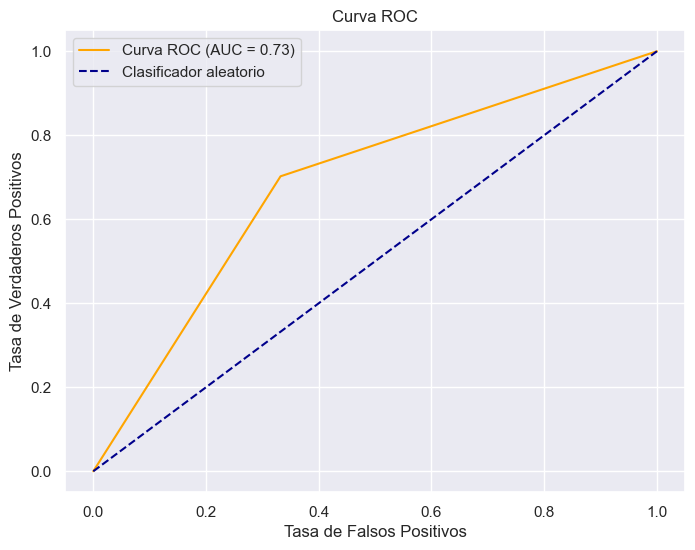

In [43]:
### Curva ROC
fpr, tpr, thresholds = roc_curve(Y_val, y_pred)


# Graficar la curva ROC
    
plt.figure('ROC Regresion Logistica',figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()


### KNN

In [44]:
#KNN

from sklearn.neighbors import KNeighborsClassifier

for i in range(6,16):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_z, Y_train)
    y_pred = neigh.predict(X_val_z)
    y_pred_score = neigh.predict_proba(X_val_z)[:,1]
    accuracy = accuracy_score(Y_val, y_pred)
    precision = precision_score(Y_val, y_pred)
    recall = recall_score(Y_val, y_pred)
    f1_sc = f1_score(Y_val, y_pred)
    roc_auc = roc_auc_score(Y_val, y_pred_score)
    
    mod_metrics = {
    'Model' : 'KKN-{n}'.format(n=i),
    'Accuracy': accuracy,
    'Precision' :precision,
    'Recall': recall,
    'F1': f1_sc,
    'ROC-AUC': roc_auc
    }
    models_metrics = models_metrics.append(mod_metrics, ignore_index=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20664\1002049634.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_metrics = models_metrics.append(mod_metrics, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_20664\1002049634.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_metrics = models_metrics.append(mod_metrics, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_20664\1002049634.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_metrics = models_metrics.append(mod_metrics, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_20664\1002049634.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

## EVALUAR MEJOR MODELO

In [47]:
models_metrics

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Regresión logist,0.720689,0.715609,0.732985,0.724193,0.795151
1,Regresión logist SKLEARN,0.720886,0.718966,0.725779,0.722356,0.795264
2,Gaussian Naive Bayes,0.685039,0.679106,0.702265,0.690491,0.734019
3,KKN-6,0.683040,0.727298,0.586247,0.649199,0.744397
4,KKN-7,0.689730,0.697037,0.671797,0.684184,0.750708
5,KKN-8,0.690891,0.729423,0.607460,0.662878,0.755414
6,KKN-9,0.695324,0.704116,0.674370,0.688922,0.759376
7,KKN-10,0.695829,0.730473,0.621205,0.671422,0.763053
8,KKN-11,0.699691,0.709342,0.677206,0.692901,0.765859
9,KKN-12,0.699237,0.730967,0.631075,0.677358,0.768034


In [70]:
y_pred_score = resultLogit.predict(np.delete(X_test_z_log, 20, 1))
y_pred = (y_pred_score>.5).astype(int)

# Mostrar la matriz de confusión y el informe de clasificación
print("Matriz de confusión:")
print(confusion_matrix(Y_test, y_pred))


accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1_sc = f1_score(Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_pred_score)

print('\nMetricas de test del modelo final:')
print(f"Accuracy del modelo: {accuracy}")
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1_sc}')
print(f'ROC-AUC: {roc_auc}')



Matriz de confusión:
[[70380 28599]
 [26578 72510]]

Metricas de test del modelo final:
Accuracy del modelo: 0.7214225489354612
Precision: 0.7171468415274604
Recall: 0.7317737768448248
F1: 0.724386479317872
ROC-AUC: 0.7952620286305808


In [83]:
sm.iolib.smpickle.save_pickle(resultLogit, 'model.pickle')
dump(result1, 'model_2.pickle')
np.save('X_test.npy', X_test_z_log)
np.save('Y_test.npy', Y_test)
